# Demo of Predictive State Smoothing (PRESS)

PRESS is a kernel smoothing technique for any type of predictive learning problem (classification, regression, ...).

This notebook shows examples of how to use the main functionality for a regression and classification problem.  Core PRESS functionality and layers, though, can be used for any learning problem with non-standard activation functions.

See also


* Goerg (2018) *[Classification using Predictive State Smoothing (PRESS): A scalable kernel classifier for high-dimensional features with variable selection](https://research.google/pubs/pub46767/)*.

* Goerg (2017) *[Predictive State Smoothing (PRESS): Scalable non-parametric regression for high-dimensional data with variable selection](https://research.google/pubs/pub46141/).*


In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import logging
import datetime
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [22]:
from pypress.keras import layers
from pypress.keras import initializers
from pypress.keras import regularizers
from pypress import utils

importlib.reload(layers)

<module 'pypress.keras.layers' from '/home/georg/Projects/pypress/pypress/keras/layers.py'>

# Utility functions and setup

In [23]:
# misc helper functions
from typing import Tuple, Any
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler


def _get_loss_activation_metrics(y: pd.Series) -> Tuple[Any, Any, Any]:

    if len(np.unique(y)) == 2:
        act = "sigmoid"
        loss_fn = "binary_crossentropy"
        metrics = [tf.keras.metrics.AUC(curve="PR", name="aupr"), tf.keras.metrics.AUC(curve="ROC", name="auc_roc")]
    else:
        act = "linear"
        loss_fn = "mse"
        metrics = [tf.keras.metrics.mean_squared_error]
        
        if (y >= 0.).all():
            act = "softplus"
            loss_fn = "mse"

    return (loss_fn, act, metrics)


def _get_recommended_callbacks():
    logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    return [tf.keras.callbacks.EarlyStopping(patience=10),
                             tensorboard_callback], logdir


def _scale_df(X, scaler = None):
    
    if scaler is None:
        scaler = RobustScaler()
        scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), scaler


def _train_test_scale(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    X_train_s, scaler = _scale_df(X_train, None)
    X_test_s, scaler = _scale_df(X_test, scaler)
    
    return (X_train, y_train, X_test, y_test), scaler


# Regression


In [24]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)

In [211]:
X, y = housing["data"], housing["target"]
X.shape, y.shape

((20640, 8), (20640,))

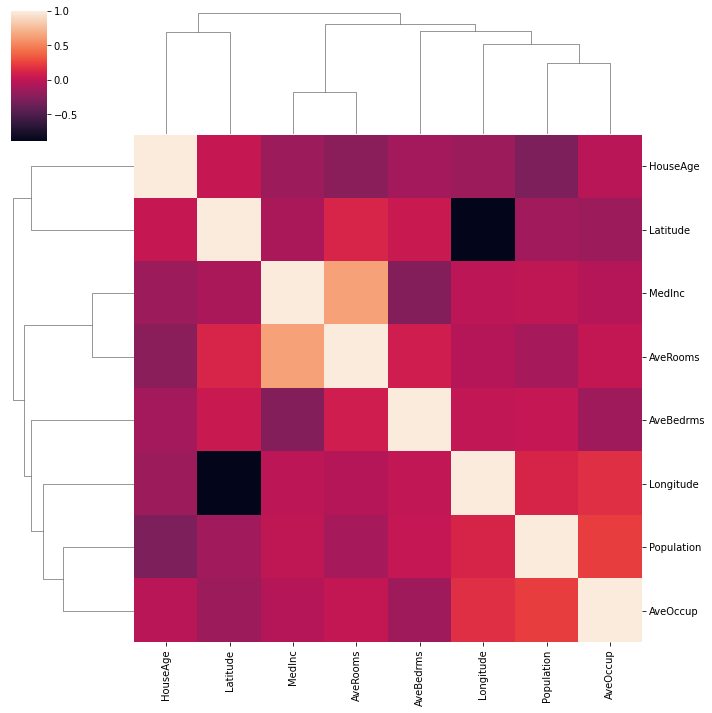

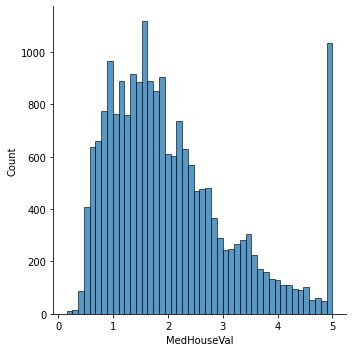

In [212]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [213]:
X = X.loc[y < 5]
y = y.loc[y < 5]

X.shape, y.shape

((19648, 8), (19648,))

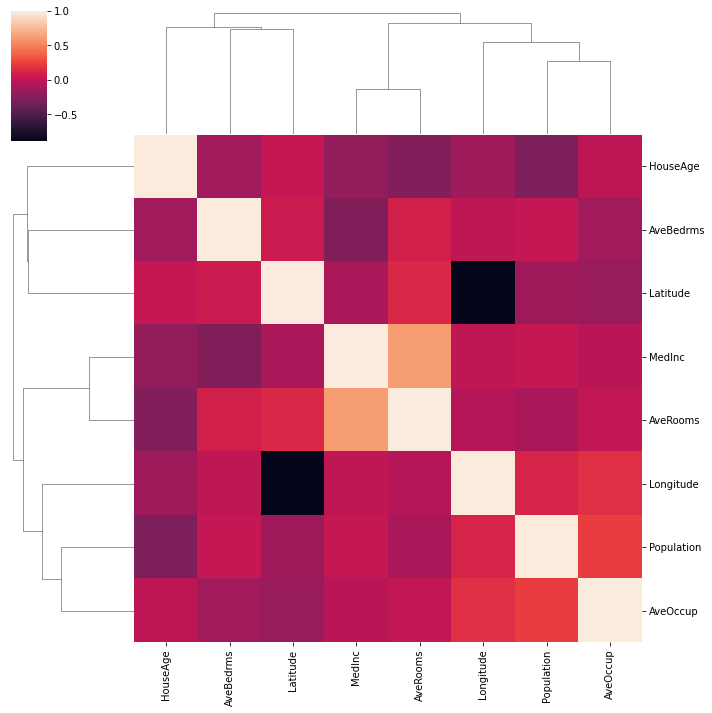

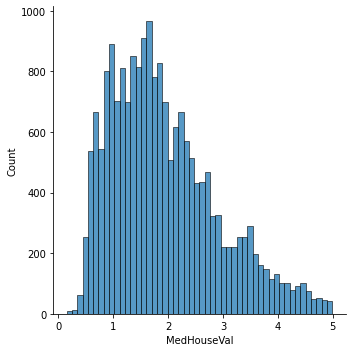

In [214]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [215]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape

(15718, 8)

In [216]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_ts)
print(act, loss_fn)

feat_input = tf.keras.layers.Input(shape=(X_tr.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(30, "relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(10, "tanh", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
eps_mapping = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(l1=0.1),
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001))
pred_states = eps_mapping(hidden)
state_mean_layer = layers.PredictiveStateMeans(units=1, activation=act)
pred = state_mean_layer(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
            metrics=metrics)
mod.summary()

softplus mse
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 8)]               0         
                                                                 
 sequential_27 (Sequential)  (None, 10)                740       
                                                                 
 predictive_state_simplex_20  (None, 5)                55        
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_20 (  (None, 1)                5         
 PredictiveStateMeans)                                           
                                                                 
Total params: 800
Trainable params: 720
Non-trainable params: 80
_________________________________________________________________


In [217]:
eps_mapping.trainable_weights

[<tf.Variable 'predictive_state_simplex_20/kernel:0' shape=(10, 5) dtype=float32, numpy=
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'predictive_state_simplex_20/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>]

In [218]:
state_mean_layer.trainable_variables

[<tf.Variable 'predictive_state_means_20/state_conditional_mean_logits:0' shape=(5, 1) dtype=float32, numpy=
 array([[-0.7818613 ],
        [ 0.5798745 ],
        [ 0.09005284],
        [ 0.525368  ],
        [-0.01202035]], dtype=float32)>]

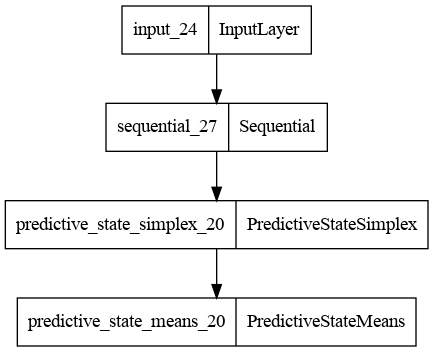

In [219]:
tf.keras.utils.plot_model(mod)

In [220]:
history = mod.fit(X_tr, y_tr, epochs=10, batch_size=32,
                  validation_data=(X_ts, y_ts),
                  callbacks=[],#_get_recommended_callbacks()
                 )

Epoch 1/10
492/492 [==============================] - 2s 2ms/step - loss: 1.1617 - mean_squared_error: 1.1472 - val_loss: 0.9416 - val_mean_squared_error: 0.9285
Epoch 2/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9579 - mean_squared_error: 0.9470 - val_loss: 0.9368 - val_mean_squared_error: 0.9281
Epoch 3/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9558 - mean_squared_error: 0.9475 - val_loss: 0.9372 - val_mean_squared_error: 0.9291
Epoch 4/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9548 - mean_squared_error: 0.9473 - val_loss: 0.9369 - val_mean_squared_error: 0.9295
Epoch 5/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9542 - mean_squared_error: 0.9475 - val_loss: 0.9339 - val_mean_squared_error: 0.9275
Epoch 6/10
492/492 [==============================] - 1s 2ms/step - loss: 0.9533 - mean_squared_error: 0.9473 - val_loss: 0.9340 - val_mean_squared_error: 0.9289
Epoch 7/10
492/492 [========

In [221]:
mod.layers[-1].state_conditional_means.numpy().ravel()

array([0.6632793, 2.0052197, 1.62271  , 1.9540174, 1.1117752],
      dtype=float32)

<AxesSubplot:>

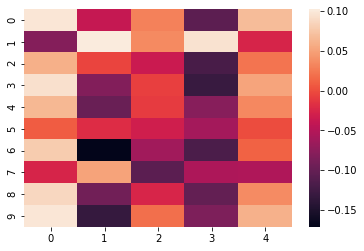

In [222]:
sns.heatmap(eps_mapping.trainable_weights[0].numpy())

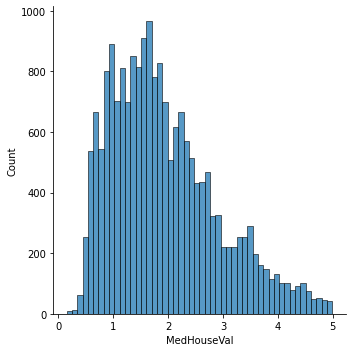

In [223]:
sns.displot(y)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


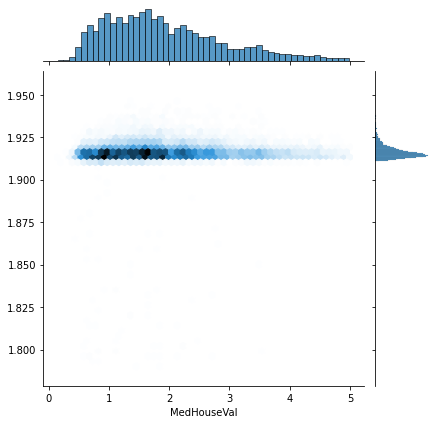

In [224]:
y_pred = mod.predict(X)

sns.jointplot(y, y_pred.ravel(), kind="hex")

(3930, 8)


<AxesSubplot:>

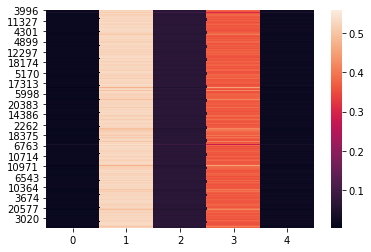

In [225]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = state_mapping(X_ts.values).numpy()
pred_emb = pd.DataFrame(pred_emb, index=X_ts.index)
sns.heatmap(pred_emb)

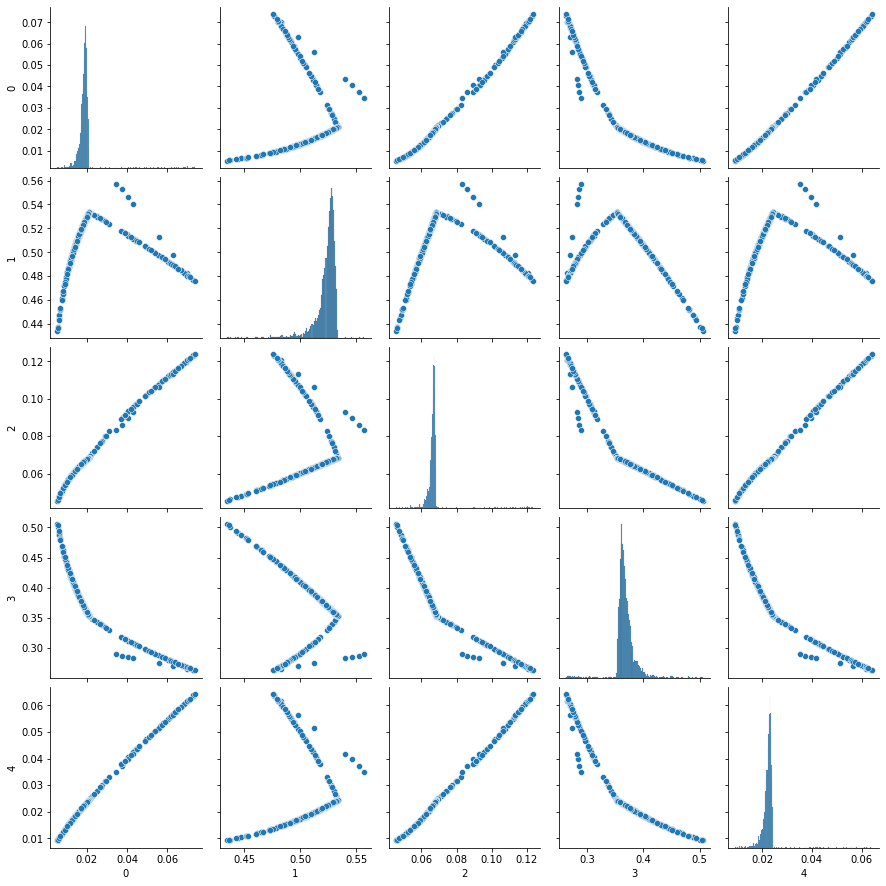

In [226]:
sns.pairplot(pred_emb)

In [227]:
pred_emb.shape

(3930, 5)

In [228]:
utils.col_normalize(pred_emb).sum(axis=0)

state
0    1.000002
1    1.000000
2    1.000003
3    0.999998
4    1.000000
dtype: float32

In [229]:
X_ts.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
3996,4.2009,7.0,4.843890,1.099714,4404.0,1.799755,34.18,-118.59
4188,3.0919,28.0,3.509554,1.088110,2670.0,2.834395,34.12,-118.22
4927,1.7132,38.0,4.408740,1.064267,1714.0,4.406170,34.00,-118.24
4119,5.5524,52.0,6.129032,1.041935,1842.0,2.970968,34.14,-118.20
4527,2.5455,47.0,3.194690,1.039823,930.0,4.115044,34.05,-118.21


In [231]:
utils.state_size(pred_emb)

state
0      75.046539
1    2055.533203
2     262.427002
3    1447.797241
4      89.196442
dtype: float32

In [232]:
utils.agg_data_by_state(pred_emb, X_ts).round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
state,,,,,,,,
0,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
1,0.52,0.52,0.52,0.52,0.52,0.52,0.52,0.52
2,0.07,0.07,0.07,0.07,0.06,0.07,0.07,0.07
3,0.37,0.37,0.37,0.37,0.38,0.37,0.37,0.37
4,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


# Classification

In [233]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

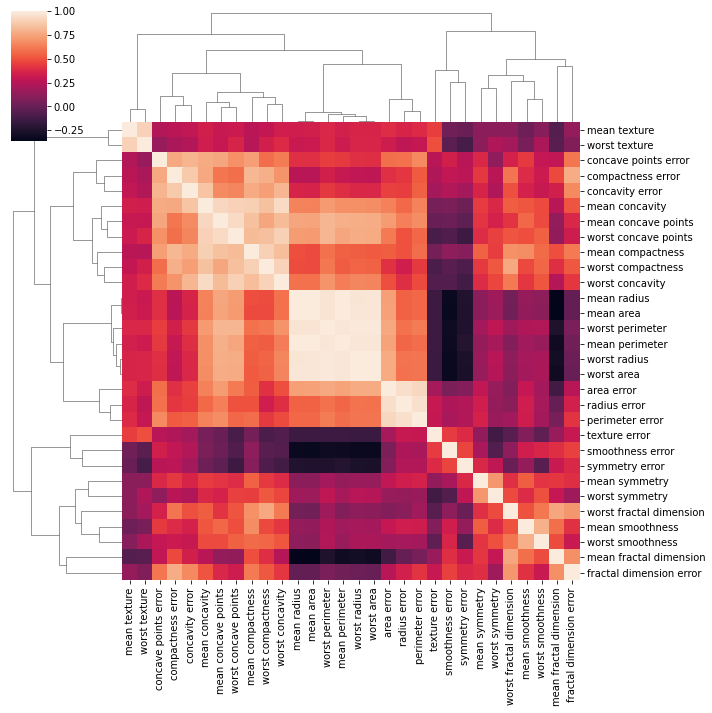

In [234]:
sns.clustermap(X.corr("spearman"))

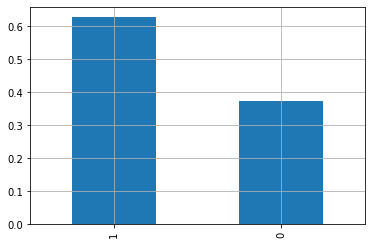

In [235]:
y.value_counts(normalize=True).plot.bar()
plt.grid()

In [253]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape, X_ts.shape

((455, 30), (114, 30))

In [237]:
loss_fn, act, metrics = _get_loss_activation_metrics(y)

feat_input = tf.keras.layers.Input(shape=(X.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "selu"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStateSimplex(n_states=5, activity_regularizer=regularizers.Uniform(10.))(hidden)
pred = layers.PredictiveStateMeans(units=1, activation=act)(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 30)]              0         
                                                                 
 sequential_28 (Sequential)  (None, 30)                3400      
                                                                 
 predictive_state_simplex_21  (None, 5)                155       
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_21 (  (None, 1)                5         
 PredictiveStateMeans)                                           
                                                                 
Total params: 3,560
Trainable params: 3,400
Non-trainable params: 160
_________________________________________________________________


In [238]:
clbks, logdir_str = _get_recommended_callbacks()

logs/20211128-164533


In [239]:
history = mod.fit(X_tr, y_tr, epochs=30, 
                  validation_data=(X_ts, y_ts),
                  callbacks=clbks,
                 )

Epoch 1/30
15/15 [==============================] - 2s 34ms/step - loss: 0.6637 - aupr: 0.8821 - auc_roc: 0.8408 - val_loss: 0.6775 - val_aupr: 0.9816 - val_auc_roc: 0.9709
Epoch 2/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6294 - aupr: 0.9628 - auc_roc: 0.9459 - val_loss: 0.6595 - val_aupr: 0.9860 - val_auc_roc: 0.9787
Epoch 3/30
15/15 [==============================] - 0s 7ms/step - loss: 0.6065 - aupr: 0.9561 - auc_roc: 0.9346 - val_loss: 0.6210 - val_aupr: 0.9866 - val_auc_roc: 0.9799
Epoch 4/30
15/15 [==============================] - 0s 7ms/step - loss: 0.5907 - aupr: 0.9720 - auc_roc: 0.9556 - val_loss: 0.6088 - val_aupr: 0.9857 - val_auc_roc: 0.9783
Epoch 5/30
15/15 [==============================] - 0s 7ms/step - loss: 0.5835 - aupr: 0.9652 - auc_roc: 0.9504 - val_loss: 0.5856 - val_aupr: 0.9865 - val_auc_roc: 0.9791
Epoch 6/30
15/15 [==============================] - 0s 7ms/step - loss: 0.5834 - aupr: 0.9651 - auc_roc: 0.9467 - val_loss: 0.5940 - val_au

In [240]:
%tensorboard --logdir $logdir_str

In [254]:
preds = pd.DataFrame({"true": y_ts, "pred": mod.predict(X_ts).ravel()})

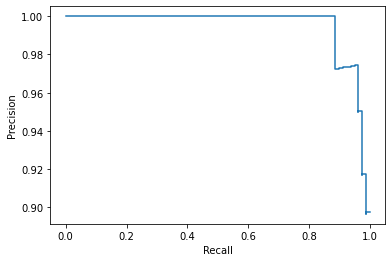

In [255]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(preds["true"], preds["pred"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


(114, 30)


<AxesSubplot:>

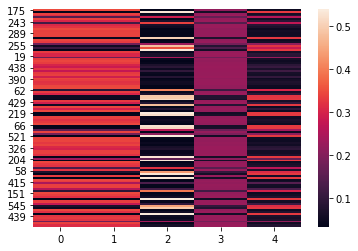

In [256]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = pd.DataFrame(state_mapping(X_ts.values).numpy(), index=X_ts.index)
sns.heatmap(pred_emb)

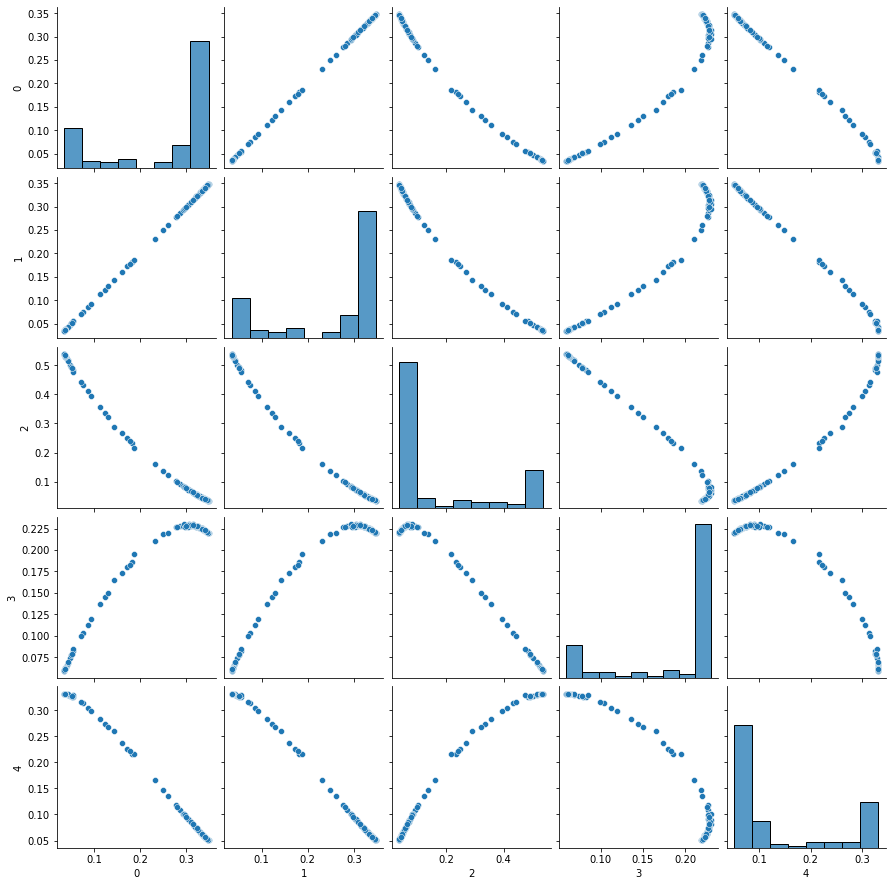

In [257]:
sns.pairplot(pred_emb)

In [258]:
X_state = utils.agg_data_by_state(X_ts, pred_emb)
X_state

,0,1,2,3,4
mean radius,12.308203,12.308078,16.767545,12.732152,15.821503
mean texture,18.632668,18.632601,20.946555,18.865767,20.478208
mean perimeter,79.213240,79.212379,109.979035,82.140193,103.466494
mean area,480.051412,480.040055,914.394640,519.169412,819.635581
mean smoothness,0.093291,0.093291,0.097601,0.093793,0.096919
mean compactness,0.081456,0.081455,0.118978,0.085363,0.111692
mean concavity,0.048095,0.048093,0.123488,0.055253,0.107932
mean concave points,0.028148,0.028146,0.070511,0.032211,0.061816
mean symmetry,0.176746,0.176746,0.179962,0.177040,0.179301
mean fractal dimension,0.062958,0.062958,0.060868,0.062759,0.061350


In [259]:
mod.layers[-1].state_conditional_means.numpy()

array([[0.79450357],
       [0.7945453 ],
       [0.21502441],
       [0.6839477 ],
       [0.3205074 ]], dtype=float32)

In [260]:
utils.state_size(pred_emb, normalize=True)

state
0    0.253522
1    0.253552
2    0.165886
3    0.188536
4    0.138504
dtype: float32

In [261]:
X_state

state,0,1,2,3,4
mean radius,12.308203,12.308078,16.767545,12.732152,15.821503
mean texture,18.632668,18.632601,20.946555,18.865767,20.478208
mean perimeter,79.213240,79.212379,109.979035,82.140193,103.466494
mean area,480.051412,480.040055,914.394640,519.169412,819.635581
mean smoothness,0.093291,0.093291,0.097601,0.093793,0.096919
mean compactness,0.081456,0.081455,0.118978,0.085363,0.111692
mean concavity,0.048095,0.048093,0.123488,0.055253,0.107932
mean concave points,0.028148,0.028146,0.070511,0.032211,0.061816
mean symmetry,0.176746,0.176746,0.179962,0.177040,0.179301
mean fractal dimension,0.062958,0.062958,0.060868,0.062759,0.061350


<AxesSubplot:>

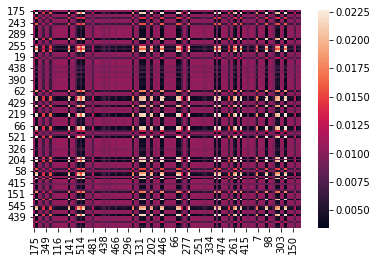

In [262]:
sns.heatmap(pred_emb.dot(utils.col_normalize(pred_emb).transpose()))

## Explain predictions

In [263]:
pred_fn = lambda x: mod.predict(x)[:, 0]

In [264]:
import shap
# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(pred_fn, X_ts)
explainer.feature_names

In [265]:
shap_values = explainer(X_ts.iloc[:20])  # ~20sec

Permutation explainer: 21it [00:25,  1.23s/it]                        


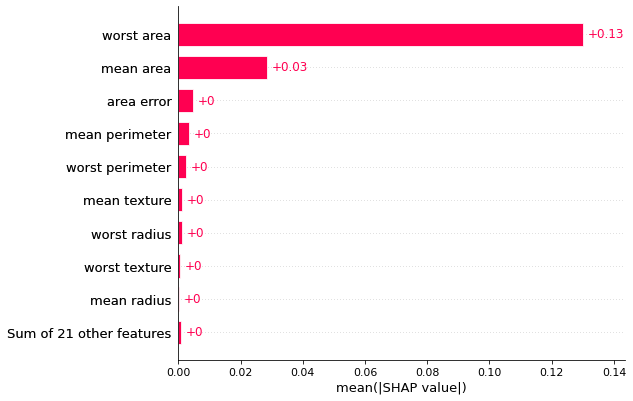

In [266]:
shap.plots.bar(shap_values)

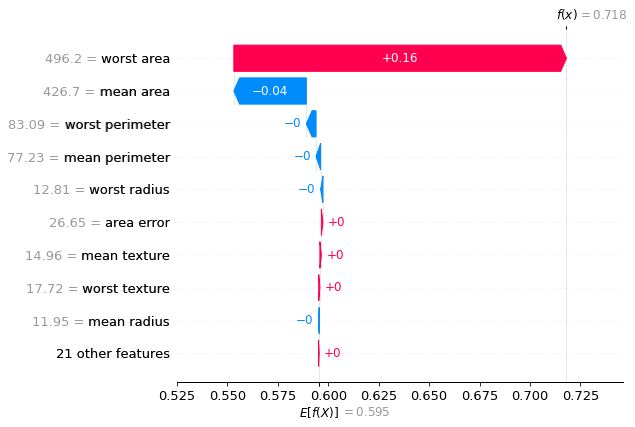

In [267]:
shap.plots.waterfall(shap_values[5])

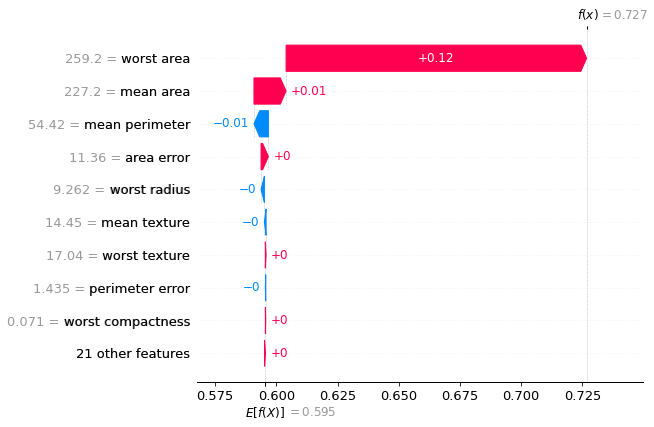

In [268]:
shap.plots.waterfall(shap_values[0])

# Example of single `PRESS()` layer

In [269]:
mod = tf.keras.Sequential()
mod.add(layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictive_state_simplex_22  (None, 6)                186       
  (PredictiveStateSimplex)                                       
                                                                 
 predictive_state_means_22 (  (None, 1)                6         
 PredictiveStateMeans)                                           
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [270]:
mod.fit(X_tr, y_tr, epochs=2)

Epoch 1/2
15/15 [==============================] - 2s 1ms/step - loss: 0.8018 - aupr: 0.7341 - auc_roc: 0.6086
Epoch 2/2
15/15 [==============================] - 0s 1ms/step - loss: 0.7751 - aupr: 0.5957 - auc_roc: 0.4976


In [273]:
mod = tf.keras.Sequential()
mod.add(layers.PRESS(units=1, n_states=6, activation="sigmoid", activity_regularizer=regularizers.DegreesOfFreedom(l1=0.1, df=2.), input_dim=X.shape[1]))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 press_4 (PRESS)             (None, 1)                 192       
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [274]:
mod.fit(X_tr, y_tr, epochs=12)

Epoch 1/12
15/15 [==============================] - 1s 1ms/step - loss: 0.6675 - aupr: 0.7926 - auc_roc: 0.6556
Epoch 2/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6689 - aupr: 0.7259 - auc_roc: 0.6881
Epoch 3/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6605 - aupr: 0.7761 - auc_roc: 0.7659
Epoch 4/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6442 - aupr: 0.8942 - auc_roc: 0.8917
Epoch 5/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6337 - aupr: 0.9263 - auc_roc: 0.9142
Epoch 6/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6246 - aupr: 0.9187 - auc_roc: 0.9180
Epoch 7/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6165 - aupr: 0.9526 - auc_roc: 0.9416
Epoch 8/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6121 - aupr: 0.9445 - auc_roc: 0.9326
Epoch 9/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6038 - aupr: 0.9404 - auc_roc: